# Kiwi Vocalization Trimming — Step-by-Step Notebook

This notebook detects and trims Kiwi vocalizations from 1-minute recordings, removing **leading and trailing silence** while preserving **only the segments containing the call**.  
It can also isolate multiple notes within a call when they are separated by silent gaps.

## Detection Method
- **Adaptive Energy/RMS Gating** *(recommended for bioacoustics)* — noise-aware thresholding with optional band-pass filtering, configurable ROI, and post-processing to merge/prune segments.

## Key Features
- **Custom ROI:** Restrict detection to a time range within the recording (e.g., 5–55 s).
- **Noise estimation controls:** Percentile-based or standard deviation thresholds with adjustable quantile (`noise_q`) and smoothing.
- **Post-processing:** Minimum segment length, merge gap size, pre/post padding, and option to keep only the longest segment.
- **Optional band-pass filter:** Focus analysis on the frequency range of interest.
- **Lightweight QC:** Generates histograms, calculates “no voiced region” statistics, and previews random trimmed examples.

## Workflow
1. **Set configuration:** Define paths, detection method, ROI, filter parameters, and thresholding settings.
2. **Preview a single file:** Plot RMS envelope, threshold, and detected segments to validate configuration.
3. **Batch process all audio files:** Save trimmed audio and a CSV log (`trimming_log.csv`) with segment details.
4. **(Optional)** Export detected notes within a call as separate files.
5. **Review QC metrics and listen to sample outputs.**

> **Tip:** Run the notebook top-to-bottom the first time. Adjust ROI and thresholds if calls are under- or over-segmented.


## 1) Imports

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm
from IPython.display import Audio, display

# Optional: SciPy (for band-pass filtering). If unavailable, we continue without filtering.
try:
    from scipy.signal import butter, filtfilt
    HAVE_SCIPY = True
except Exception as e:
    print("SciPy is not available; band-pass filtering will be skipped.\n", e)
    HAVE_SCIPY = False

# Optional: Matplotlib (for plots). If unavailable, we continue without plots.
try:
    import matplotlib.pyplot as plt
    HAVE_MPL = True
except Exception as e:
    print("Matplotlib is not available; plots will be skipped.\n", e)
    HAVE_MPL = False

# Matplotlib settings: keep defaults (no custom styles/colors)


## 2) Configuration

Before running the batch processing, configure the main parameters here.

- **`input_dir` / `output_dir`** — Folders containing the original audio files and where processed files will be saved.  
- **`method`** — `"energy"` — adaptive RMS/energy gating with noise-aware thresholding.  
- **`export_mode`** —  
  - `"trim_edges"` — Save a single file per input, with leading/trailing silence removed.  
  - `"all_segments"` — Save each detected segment as a separate file.  
- **`SAVE_NOTES`** —  
  - `False` (default): Only trims the full vocalization (leading/trailing silence removed). Does not detect or save individual notes inside the vocalization.  
  - `True`: In addition to trimming the full vocalization, detects and saves **each note** found within it as separate files, using the configured note detection parameters.  
  - Recommended to keep `False` for speed and fewer files; enable `True` only when detailed per-note analysis is needed.  

> **Tip:** Adjust the ROI (`ANALYSIS_ROI`) if your calls start early or end late in the recording. This can prevent false detections in unrelated regions.


In [2]:
# === Paths ===

cwd = Path.cwd()
project_root = cwd.parents[1]
input_dir = project_root / "Original_datasets" / "Kiwi" # Path to input directory
output_dir = project_root / "Original_datasets" / "KiwiTrimmed"

output_dir.mkdir(parents=True, exist_ok=True)

print(f"Input directory: {input_dir.resolve()}")
print(f"Output directory: {output_dir.resolve()}")

# === Method ===
method = "energy"           # options: "energy", "librosa_trim"
export_mode = "trim_edges"  # options: "trim_edges", "all_segments"

# === Audio I/O ===
target_sr = None            # None = keep original sample rate; otherwise specify, e.g., 32000

# === Band-pass (optional) ===
bandpass_low_hz  = 1000      # e.g., None, 800
bandpass_high_hz = 3600     # e.g., None, 3600

# === Frame/analysis parameters ===
frame_length = 1024
hop_length   = 256
ANALYSIS_ROI = (5.0, 55.0)   # detect only between 15s and 50s (adjust as needed)

# === Noise & thresholding ===
noise_estimate_sec = 8.0       # seconds from start and end used to estimate noise
threshold_mode     = "percentile"  # "std" or "percentile"
k_std              = 5.0       # used if threshold_mode == "std"
noise_percentile   = 98.0      # used if threshold_mode == "percentile"
noise_strategy     = "quantile"    # "quantile" or "headtail"
noise_q            = 0.50      # lower percentage considered "noise"
smooth_win_sec     = 0.20      # smoothing window for RMS

# === Post-processing (merge/prune/pad) ===
min_segment_sec = 0.5          # drop shorter chunks as spurious
merge_gap_sec   = 0.1          # merge small silent gaps between voiced chunks
prepad_sec      = 0.10         # pad before detected start
postpad_sec     = 0.10         # pad after detected end
SAVE_NOTES      = False        # save notes in a CSV file
KEEP_ONLY_LONGEST_SEGMENT = False  # keep only the longest segment in each file

# === Batch QC (lightweight) ===
BATCH_QC_EVERY = 0     # 0 = off, 10 = save a QC plot for every 10th file
BATCH_QC_DIR = output_dir / "_qc"   # folder for QC images

# === File pattern ===
extensions = (".wav", ".WAV")  # adjust if needed


# === Post-clustering (stray segment suppression) ===
ENABLE_CLUSTER_FILTER = True
BIG_GAP_SEC = 4.5                # if gap > 4.5s, start a new cluster
MAIN_CLUSTER_MODE = "duration"   # "duration" | "span" | "count"
MIN_MAIN_CLUSTER_NOTES = 6       # require at least N segments in the main cluster (optional)
MIN_MAIN_CLUSTER_DURATION = 5.0  # require at least N seconds total duration (optional)

# Optional: drop short singletons far from others
DROP_ISOLATED_TINY = True
ISOLATION_GAP_SEC = 2.0          # must be this far from neighbors to be considered "isolated"
MAX_TINY_SEC = 0.7               # if a segment is <= this length and isolated, drop it


Input directory: /teamspace/studios/this_studio/Original_datasets/Kiwi
Output directory: /teamspace/studios/this_studio/Original_datasets/KiwiTrimmed


## 3) Helper functions

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Build a Butterworth band-pass/low/high filter.
    Returns (b, a) or (None, None) if filtering is disabled/unavailable.
    """
    if not HAVE_SCIPY or (lowcut is None and highcut is None):
        return None, None

    nyq = 0.5 * fs
    # Normalize (and validate) cutoffs
    low  = lowcut  / nyq if lowcut  is not None else None
    high = highcut / nyq if highcut is not None else None

    # Guard against invalid values (e.g., > Nyquist or inverted)
    if low is not None and (low <= 0 or low >= 1):
        low = None
    if high is not None and (high <= 0 or high >= 1):
        high = None
    if low is not None and high is not None and low >= high:
        # Degenerate band; disable filter gracefully
        return None, None

    if low is None and high is None:
        return None, None
    elif low is None:
        b, a = butter(order, high, btype="low")
    elif high is None:
        b, a = butter(order, low, btype="high")
    else:
        b, a = butter(order, [low, high], btype="band")
    return b, a


def apply_bandpass(y, sr, lowcut, highcut):
    """
    Apply the band-pass (or low/high) filter if available; otherwise return y unchanged.
    """
    ba = butter_bandpass(lowcut, highcut, sr, order=4)
    if ba[0] is None:
        return y
    b, a = ba
    return filtfilt(b, a, y)


def rms_envelope(y, frame_length=2048, hop_length=512):
    """
    Frame-wise RMS (no librosa dependency).
    Mirroring librosa's framing alignment: reflect-pad by half a frame.
    """
    assert hop_length > 0, "hop_length must be > 0"
    y_pad = np.pad(y, (frame_length // 2, frame_length // 2), mode="reflect")
    n_frames = 1 + (len(y_pad) - frame_length) // hop_length
    n_frames = max(1, int(n_frames))

    rms = np.empty(n_frames, dtype=np.float32)
    for i in range(n_frames):
        frame = y_pad[i * hop_length : i * hop_length + frame_length]
        # Use float64 inside the mean for numerical stability
        rms[i] = np.sqrt(np.mean(frame.astype(np.float64) ** 2))
    return rms


def frames_to_time(n_frames, sr, hop_length):
    idx = np.arange(n_frames, dtype=np.float64)
    return idx * (hop_length / sr)


def detect_voiced_regions(
    y, sr, frame_length, hop_length,
    noise_estimate_sec=3.0,          # ignored if noise_strategy="quantile"
    threshold_mode="percentile",     # "std" or "percentile"
    k_std=3.0,
    noise_percentile=92.0,           # typical range 90–95
    bandpass_low_hz=None,
    bandpass_high_hz=None,
    min_segment_sec=0.15,
    merge_gap_sec=0.10,
    noise_strategy="quantile",       # "quantile" (robust) or "headtail" (legacy)
    noise_q=0.30,                    # lower fraction considered "noise floor"
    smooth_win_sec=0.20              # median smoothing window over the RMS
):
    """
    Energy/RMS-based detector with:
      - optional band-pass
      - robust noise-floor estimation (quantile of smoothed RMS)
      - thresholding by STD or percentile over the noise set
      - simple post-processing: merge small gaps, drop short segments
    Returns:
      segments_sec (list of (start_s, end_s)),
      thr (float), times (np.ndarray), rms (np.ndarray), voiced (bool array)
    """
    # 1) Optional band-pass
    y_proc = apply_bandpass(y, sr, bandpass_low_hz, bandpass_high_hz)

    # 2) RMS
    rms = rms_envelope(y_proc, frame_length=frame_length, hop_length=hop_length)
    times = frames_to_time(len(rms), sr, hop_length)

    # 3) Light smoothing (median) to estimate the floor more robustly
    win = max(1, int(round((smooth_win_sec * sr) / hop_length)))
    if win > 1:
        pad = win // 2
        rms_pad = np.pad(rms, (pad, pad), mode="edge")
        rms_smooth = np.empty_like(rms)
        for i in range(len(rms)):
            window = rms_pad[i : i + win]
            rms_smooth[i] = np.median(window)
    else:
        rms_smooth = rms

    # 4) Build the noise set
    if noise_strategy == "quantile":
        # Use the lowest-energy portion (by quantile) as “noise”
        thr_val = np.quantile(rms_smooth, noise_q)
        noise_mask = rms_smooth <= thr_val
        noise_rms = rms[noise_mask]
        # Safety fallback if mask is too small
        if noise_rms.size < 8:
            noise_rms = np.sort(rms)[:max(8, len(rms)//10)]
    elif noise_strategy == "headtail":
        n = int(noise_estimate_sec * sr)
        head = y_proc[:n] if len(y_proc) >= n else y_proc
        tail = y_proc[-n:] if len(y_proc) >= n else y_proc
        rms_head = rms_envelope(head, frame_length=frame_length, hop_length=hop_length)
        rms_tail = rms_envelope(tail, frame_length=frame_length, hop_length=hop_length)
        noise_rms = np.concatenate([rms_head, rms_tail])
    else:
        raise ValueError("Unknown noise_strategy")

    # 5) Threshold
    if threshold_mode == "std":
        thr = noise_rms.mean() + k_std * noise_rms.std()
    elif threshold_mode == "percentile":
        thr = np.percentile(noise_rms, noise_percentile)
    else:
        raise ValueError("Unknown threshold_mode")

    # 6) Binarize + merge gaps + prune short segments
    voiced = rms > thr
    min_len_frames   = int(np.ceil(min_segment_sec * sr / hop_length))
    merge_gap_frames = int(np.ceil(merge_gap_sec   * sr / hop_length))

    segments = []
    start = None
    gap = 0
    for i, v in enumerate(voiced):
        if v:
            if start is None:
                start = i
            gap = 0
        else:
            if start is not None:
                gap += 1
                if gap > merge_gap_frames:
                    end = i - gap + 1
                    if end - start >= min_len_frames:
                        segments.append((start, end))
                    start = None
                    gap = 0
    if start is not None:
        end = len(voiced)
        if end - start >= min_len_frames:
            segments.append((start, end))

    # To seconds
    segments_sec = [(s * hop_length / sr, e * hop_length / sr) for s, e in segments]
    return segments_sec, thr, times, rms, voiced


def apply_padding_to_bounds(segments, prepad_sec, postpad_sec, total_dur):
    """
    Convert a list of detected segments into a single [start, end] range
    with padding, clipped to the recording duration.
    """
    if not segments:
        return None
    start = max(0.0, segments[0][0] - prepad_sec)
    end   = min(total_dur, segments[-1][1] + postpad_sec)
    return (start, end)


def save_qc_plot(y, sr, frame_length, hop_length,
                 roi_start, roi_end,
                 times_roi, rms_roi, thr,
                 segments_global, bounds, dur,
                 out_png_path):
    """
    Save a lightweight QC PNG:
      - RMS over full file
      - RMS over ROI (shifted to global time)
      - Threshold (from ROI)
      - Detected segments (global time)
      - Final trim bounds + ROI shading
    """
    if not ('HAVE_MPL' in globals() and HAVE_MPL):
        return

    # Full-minute RMS for context
    rms_full = rms_envelope(y, frame_length=frame_length, hop_length=hop_length)
    times_full = frames_to_time(len(rms_full), sr, hop_length)

    plt.figure(figsize=(7, 3.8))
    plt.title("QC: RMS, ROI, segments, and bounds")

    # Full RMS (context)
    plt.plot(times_full, rms_full, label="RMS (full)", alpha=0.25)

    # ROI RMS (shifted to global time)
    if times_roi is not None and rms_roi is not None:
        plt.plot(times_roi + roi_start, rms_roi, label="RMS (ROI)")

    # Threshold (scalar from ROI)
    if thr is not None:
        plt.axhline(thr, linestyle="--", label="Threshold (ROI)")

    # Shade ROI
    plt.axvspan(roi_start, roi_end, color='gray', alpha=0.08, label="ROI")

    # Segments (global)
    if segments_global:
        for (s, e) in segments_global:
            plt.axvspan(s, e, color='green', alpha=0.20)

    # Final bounds
    if bounds is not None:
        bs, be = bounds
        plt.axvline(bs, color='red', linestyle='--', linewidth=1.2)
        plt.axvline(be, color='red', linestyle='--', linewidth=1.2)

    plt.xlabel("Time (s)")
    plt.ylabel("RMS")
    plt.xlim(0, dur)
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    try:
        out_png_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_png_path, dpi=120)
    finally:
        plt.close()
        

def _clusters_by_gap(segments_sec, big_gap_sec=4.0):
    """
    Group segments into clusters by large temporal gaps.
    segments_sec must be sorted (list of (s, e)).
    """
    if not segments_sec:
        return []

    clusters, cur = [], []
    prev_end = None
    for (s, e) in segments_sec:
        if not cur:
            cur = [(s, e)]
            prev_end = e
            continue
        if s - prev_end <= big_gap_sec:
            cur.append((s, e))
        else:
            clusters.append(cur)
            cur = [(s, e)]
        prev_end = e
    if cur:
        clusters.append(cur)
    return clusters


def _pick_main_cluster(clusters, mode="duration"):
    """
    Select the main cluster by:
      - "duration": max sum of (e - s)
      - "span":     max (last_end - first_start)
      - "count":    max number of segments
    """
    if not clusters:
        return []
    if mode == "duration":
        key_fn = lambda cl: sum((e - s) for (s, e) in cl)
    elif mode == "span":
        key_fn = lambda cl: (cl[-1][1] - cl[0][0])
    elif mode == "count":
        key_fn = lambda cl: len(cl)
    else:
        key_fn = lambda cl: sum((e - s) for (s, e) in cl)
    return max(clusters, key=key_fn)


def _drop_isolated_tiny(segments_sec, isolation_gap_sec=4.0, max_tiny_sec=0.6):
    """
    Drop segments that are both very short (<= max_tiny_sec) and isolated
    (gap before >= isolation_gap_sec and gap after >= isolation_gap_sec).
    """
    if not segments_sec:
        return segments_sec

    segs = []
    n = len(segments_sec)
    for i, (s, e) in enumerate(segments_sec):
        dur = e - s
        prev_gap = (s - segments_sec[i-1][1]) if i > 0 else float("inf")
        next_gap = (segments_sec[i+1][0] - e) if i < n-1 else float("inf")
        if dur <= max_tiny_sec and prev_gap >= isolation_gap_sec and next_gap >= isolation_gap_sec:
            # isolated tiny blip -> drop
            continue
        segs.append((s, e))
    return segs


def post_cluster_filter(segments_sec,
                        big_gap_sec=4.0,
                        mode="duration",
                        min_notes=None,
                        min_duration=None,
                        drop_isolated_tiny=False,
                        isolation_gap_sec=4.0,
                        max_tiny_sec=0.6):
    """
    Cluster segments by large gaps and keep only the main cluster.
    Optionally drop isolated tiny segments before clustering.
    """
    if not segments_sec:
        return segments_sec

    segments_sec = sorted(segments_sec)

    if drop_isolated_tiny:
        segments_sec = _drop_isolated_tiny(segments_sec, isolation_gap_sec, max_tiny_sec)
        if not segments_sec:
            return []

    clusters = _clusters_by_gap(segments_sec, big_gap_sec=big_gap_sec)
    if len(clusters) <= 1:
        return segments_sec  # nothing to filter

    main = _pick_main_cluster(clusters, mode=mode)

    # Optional guards
    if min_notes is not None and len(main) < min_notes:
        # If the “main” cluster fails the guard, keep the original set
        return segments_sec
    if min_duration is not None and sum((e - s) for (s, e) in main) < min_duration:
        return segments_sec

    return main


## 4) Preview on a single file (validate thresholds)
Pick one file and visualize the RMS, threshold, and detected regions before running the batch.


Preview file: /teamspace/studios/this_studio/Original_datasets/Kiwi/F1/Hawdon-ClydeNest201213_20121031_200007_5906-GSKfemale.wav
Sample rate: 8000 Hz, Duration: 60.00 s
Detected segments (s): [(19.848, 21.224), (21.448, 22.312), (22.536, 23.368), (23.592, 25.384), (25.544, 26.344), (26.504, 29.256), (29.416, 31.304), (31.56, 32.424), (32.68, 33.544), (33.832, 34.824), (35.016, 35.848), (36.232, 37.096), (37.512, 38.504), (38.664, 40.968), (41.48, 42.312), (42.888, 43.72), (44.296, 45.16), (45.8, 46.664), (47.432, 48.296)]
Number of segments: 19
Trim bounds (s): (19.747999999999998, 48.396)


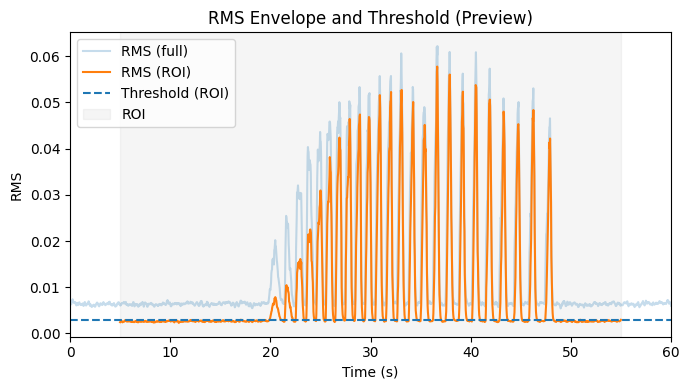

Saved preview trim to: /teamspace/studios/this_studio/Original_datasets/KiwiTrimmed/F1/Hawdon-ClydeNest201213_20121031_200007_5906-GSKfemale_trim.wav


In [4]:
# --- Preview on a single file (ROI detection, full-minute plot, optional save) ---

# 0) Pick one file
example_files = [p for p in input_dir.rglob("*") if p.suffix in extensions]
assert len(example_files) > 0, f"No audio files found in {input_dir}"
example_path = example_files[0]
print("Preview file:", example_path)

# 1) Load audio (soundfile, mono)
y, sr = sf.read(str(example_path), always_2d=False)
if y.ndim > 1:
    y = y.mean(axis=1)  # mono
y = y.astype(np.float32)

dur = len(y) / sr
print(f"Sample rate: {sr} Hz, Duration: {dur:.2f} s")

# 2) Build ROI slice (detection only)
roi_start, roi_end = 0.0, dur
if ANALYSIS_ROI is not None:
    rs, re = ANALYSIS_ROI
    # clamp to [0, dur] and ensure start < end
    rs = max(0.0, min(float(rs), dur))
    re = max(0.0, min(float(re), dur))
    if re > rs:
        roi_start, roi_end = rs, re
i0, i1 = int(roi_start * sr), int(roi_end * sr)
y_roi = y[i0:i1]

# 3) Detect segments on ROI
segments_sec, thr, times, rms, voiced = detect_voiced_regions(
    y_roi, sr, frame_length, hop_length,
    threshold_mode=threshold_mode,
    noise_percentile=noise_percentile,
    bandpass_low_hz=bandpass_low_hz,
    bandpass_high_hz=bandpass_high_hz,
    min_segment_sec=min_segment_sec,
    merge_gap_sec=merge_gap_sec,
    noise_strategy=noise_strategy,
    noise_q=noise_q,
    smooth_win_sec=smooth_win_sec
)

# Shift segments to global time
segments_sec = [(s + roi_start, e + roi_start) for (s, e) in segments_sec]

# 4) Fallback: lower percentile if nothing was detected (percentile mode only)
if not segments_sec and threshold_mode == "percentile":
    for delta in (3.0, 6.0, 9.0):
        segments2, thr2, times2, rms2, voiced2 = detect_voiced_regions(
            y_roi, sr, frame_length, hop_length,
            threshold_mode="percentile",
            noise_percentile=max(50.0, noise_percentile - delta),
            bandpass_low_hz=bandpass_low_hz,
            bandpass_high_hz=bandpass_high_hz,
            min_segment_sec=min_segment_sec,
            merge_gap_sec=merge_gap_sec,
            noise_strategy=noise_strategy,
            noise_q=noise_q,
            smooth_win_sec=smooth_win_sec
        )
        if segments2:
            segments_sec = [(s + roi_start, e + roi_start) for (s, e) in segments2]
            thr, times, rms, voiced = thr2, times2, rms2, voiced2
            print(f"[Retry] Success lowering noise_percentile to {noise_percentile - delta}")
            break

# After segments_sec has been shifted to global time and after fallback:
if 'ENABLE_CLUSTER_FILTER' in globals() and ENABLE_CLUSTER_FILTER and segments_sec:
    segments_sec = post_cluster_filter(
        segments_sec,
        big_gap_sec=BIG_GAP_SEC,
        mode=MAIN_CLUSTER_MODE,
        min_notes=MIN_MAIN_CLUSTER_NOTES,
        min_duration=MIN_MAIN_CLUSTER_DURATION,
        drop_isolated_tiny=('DROP_ISOLATED_TINY' in globals() and DROP_ISOLATED_TINY),
        isolation_gap_sec=ISOLATION_GAP_SEC if 'ISOLATION_GAP_SEC' in globals() else 4.0,
        max_tiny_sec=MAX_TINY_SEC if 'MAX_TINY_SEC' in globals() else 0.6
    )


# 5) Optional: keep only the longest contiguous segment
if 'KEEP_ONLY_LONGEST_SEGMENT' in globals() and KEEP_ONLY_LONGEST_SEGMENT and segments_sec:
    segments_sec = [max(segments_sec, key=lambda se: se[1] - se[0])]

# 6) Build trim bounds (first-to-last segment with padding)
bounds = apply_padding_to_bounds(segments_sec, prepad_sec, postpad_sec, dur)

print("Detected segments (s):", segments_sec)
print("Number of segments:", len(segments_sec))
print("Trim bounds (s):", bounds)

# 7) Plot: full-minute RMS + ROI RMS (shifted) + threshold (ROI)
if 'HAVE_MPL' in globals() and HAVE_MPL:
    # Full signal RMS for context
    rms_full = rms_envelope(y, frame_length=frame_length, hop_length=hop_length)
    times_full = frames_to_time(len(rms_full), sr, hop_length)

    plt.figure(figsize=(7, 4))
    plt.title("RMS Envelope and Threshold (Preview)")

    # Full-minute RMS (context)
    plt.plot(times_full, rms_full, label="RMS (full)", alpha=0.25)

    # ROI RMS (shifted to global time)
    plt.plot(times + roi_start, rms, label="RMS (ROI)")

    # Threshold (scalar from ROI; draw across the plot for reference)
    plt.axhline(thr, linestyle="--", label="Threshold (ROI)")

    # Shade the ROI to make the detection interval clear
    plt.axvspan(roi_start, roi_end, color='gray', alpha=0.08, label="ROI")

    plt.xlabel("Time (s)")
    plt.ylabel("RMS")
    plt.xlim(0, dur)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 8) Listen and optionally save the trimmed audio and notes
display(Audio(y, rate=sr))
y_trim = None
if bounds is not None:
    start_s, end_s = bounds
    y_trim = y[int(start_s * sr): int(end_s * sr)]
    display(Audio(y_trim, rate=sr))
else:
    print("No voiced region found with current parameters (even after fallback).")

# Prepare output directory
out_subdir = output_dir / example_path.parent.relative_to(input_dir)
out_subdir.mkdir(parents=True, exist_ok=True)

# Save trimmed WAV (only if we have bounds)
if y_trim is not None:
    out_wav = out_subdir / f"{example_path.stem}_trim.wav"
    sf.write(str(out_wav), y_trim, sr)
    print("Saved preview trim to:", out_wav)

# Optional: save per-note table
if 'SAVE_NOTES' in globals() and SAVE_NOTES and segments_sec:
    notes = []
    for k, (s, e) in enumerate(segments_sec):
        notes.append({
            "file": example_path.name,
            "note_index": k,
            "start_s": float(s),
            "end_s": float(e),
            "duration_s": float(e - s)
        })
    notes_df = pd.DataFrame(notes)
    out_csv = out_subdir / f"{example_path.stem}_notes.csv"
    notes_df.to_csv(out_csv, index=False)
    print("Saved note table to:", out_csv)


## 5) Batch processing
This cell processes all files in `input_dir` and writes trimmed audio + a CSV log.


In [5]:
# Optional: resampling support (kept for completeness; you can set target_sr=None to skip)
if 'HAVE_SCIPY' in globals() and HAVE_SCIPY:
    try:
        from scipy.signal import resample_poly
        HAVE_RESAMPLE = True
    except Exception:
        HAVE_RESAMPLE = False
else:
    HAVE_RESAMPLE = False

log_rows = []
processed = 0

files = [p for p in input_dir.rglob("*") if p.suffix in extensions]

for idx, path in enumerate(tqdm(files, desc="Processing")):
    # --- Load audio (soundfile) ---
    y, sr = sf.read(str(path), always_2d=False)
    if y.ndim > 1:
        y = y.mean(axis=1)  # mono
    y = y.astype(np.float32)

    # --- (Optional) Resampling if requested and available ---
    if target_sr is not None and sr != target_sr:
        if HAVE_RESAMPLE:
            from math import gcd
            g = gcd(int(target_sr), int(sr))
            up, down = int(target_sr // g), int(sr // g)
            y = resample_poly(y, up, down).astype(np.float32)
            sr = int(target_sr)
        else:
            print(f"[WARN] SciPy/resample not available. Keeping sr={sr} for {path.name}")


    dur = len(y) / sr

    # --- ROI (detection only) ---
    roi_start, roi_end = 0.0, dur
    if ANALYSIS_ROI is not None:
        rs, re = ANALYSIS_ROI
        rs = max(0.0, min(float(rs), dur))
        re = max(0.0, min(float(re), dur))
        if re > rs:
            roi_start, roi_end = rs, re
    i0, i1 = int(roi_start * sr), int(roi_end * sr)
    y_roi = y[i0:i1]

    # --- Output subdir ---
    file_stem = path.stem
    parent_rel = path.parent.relative_to(input_dir)
    out_subdir = output_dir / parent_rel
    out_subdir.mkdir(parents=True, exist_ok=True)

    if method == "energy":
        # 1) Detection on ROI
        segments_sec, thr, times, rms, voiced = detect_voiced_regions(
            y_roi, sr, frame_length, hop_length,
            threshold_mode=threshold_mode,
            noise_percentile=noise_percentile,
            bandpass_low_hz=bandpass_low_hz,
            bandpass_high_hz=bandpass_high_hz,
            min_segment_sec=min_segment_sec,
            merge_gap_sec=merge_gap_sec,
            noise_strategy=noise_strategy,
            noise_q=noise_q,
            smooth_win_sec=smooth_win_sec
        )
        # Shift to global time
        segments_sec = [(s + roi_start, e + roi_start) for (s, e) in segments_sec]

        # 2) Fallback if needed
        retry_used = None
        if not segments_sec and threshold_mode == "percentile":
            for delta in (3.0, 6.0, 9.0):
                seg2, thr2, times2, rms2, voiced2 = detect_voiced_regions(
                    y_roi, sr, frame_length, hop_length,
                    threshold_mode="percentile",
                    noise_percentile=max(50.0, noise_percentile - delta),
                    bandpass_low_hz=bandpass_low_hz,
                    bandpass_high_hz=bandpass_high_hz,
                    min_segment_sec=min_segment_sec,
                    merge_gap_sec=merge_gap_sec,
                    noise_strategy=noise_strategy,
                    noise_q=noise_q,
                    smooth_win_sec=smooth_win_sec
                )
                if seg2:
                    segments_sec = [(s + roi_start, e + roi_start) for (s, e) in seg2]
                    thr, times, rms, voiced = thr2, times2, rms2, voiced2
                    retry_used = noise_percentile - delta
                    break
        
        # After segments_sec has been shifted to global time and after fallback:
        if 'ENABLE_CLUSTER_FILTER' in globals() and ENABLE_CLUSTER_FILTER and segments_sec:
            segments_sec = post_cluster_filter(
                segments_sec,
                big_gap_sec=BIG_GAP_SEC,
                mode=MAIN_CLUSTER_MODE,
                min_notes=MIN_MAIN_CLUSTER_NOTES,
                min_duration=MIN_MAIN_CLUSTER_DURATION,
                drop_isolated_tiny=('DROP_ISOLATED_TINY' in globals() and DROP_ISOLATED_TINY),
                isolation_gap_sec=ISOLATION_GAP_SEC if 'ISOLATION_GAP_SEC' in globals() else 4.0,
                max_tiny_sec=MAX_TINY_SEC if 'MAX_TINY_SEC' in globals() else 0.6
            )

        # 3) Handle “none found”
        if not segments_sec:
            log_rows.append({
                "file": str(path.name),
                "original_duration_s": float(dur),
                "kept_mode": "none_found",
                "start_s": None,
                "end_s": None,
                "trimmed_duration_s": 0.0,
                "n_notes": 0,
                "noise_percentile_used": retry_used if retry_used is not None else noise_percentile
            })
            processed += 1
            continue

        # 4) Optional: single main block
        if 'KEEP_ONLY_LONGEST_SEGMENT' in globals() and KEEP_ONLY_LONGEST_SEGMENT:
            segments_sec = [max(segments_sec, key=lambda se: se[1] - se[0])]

        # 5) Optional: per-note CSV
        if 'SAVE_NOTES' in globals() and SAVE_NOTES:
            note_rows = []
            for k, (s, e) in enumerate(segments_sec):
                note_rows.append({
                    "file": path.name,
                    "note_index": k,
                    "start_s": float(s),
                    "end_s": float(e),
                    "duration_s": float(e - s)
                })
            notes_df = pd.DataFrame(note_rows)
            notes_csv = out_subdir / f"{file_stem}_notes.csv"
            notes_df.to_csv(notes_csv, index=False)

        # 6) Export audio
        if export_mode == "trim_edges":
            bounds = apply_padding_to_bounds(segments_sec, prepad_sec, postpad_sec, dur)
            start_s, end_s = bounds
            y_out = y[int(start_s * sr): int(end_s * sr)]
            out_path = out_subdir / f"{file_stem}_trim.wav"
            sf.write(str(out_path), y_out, sr)

            log_rows.append({
                "file": str(path.name),
                "original_duration_s": float(dur),
                "kept_mode": "trim_edges",
                "start_s": float(start_s),
                "end_s": float(end_s),
                "trimmed_duration_s": float(end_s - start_s),
                "n_notes": len(segments_sec),
                "noise_percentile_used": retry_used if retry_used is not None else noise_percentile
            })

        elif export_mode == "all_segments":
            for k, (s, e) in enumerate(segments_sec):
                s2 = max(0.0, s - prepad_sec)
                e2 = min(dur, e + postpad_sec)
                y_out = y[int(s2 * sr): int(e2 * sr)]
                out_path = out_subdir / f"{file_stem}_seg{k:02d}.wav"
                sf.write(str(out_path), y_out, sr)
                log_rows.append({
                    "file": str(path.name),
                    "original_duration_s": float(dur),
                    "kept_mode": "segment",
                    "start_s": float(s2),
                    "end_s": float(e2),
                    "trimmed_duration_s": float(e2 - s2),
                    "note_index": k,
                    "noise_percentile_used": retry_used if retry_used is not None else noise_percentile
                })
        else:
            raise ValueError("Unknown export_mode")

        # 7) Lightweight QC (save every Nth file)
        if ('HAVE_MPL' in globals() and HAVE_MPL and
            'BATCH_QC_EVERY' in globals() and isinstance(BATCH_QC_EVERY, int) and BATCH_QC_EVERY > 0 and
            idx % BATCH_QC_EVERY == 0):

            qc_dir = BATCH_QC_DIR if 'BATCH_QC_DIR' in globals() else (output_dir / "_qc")
            qc_png = qc_dir / f"{file_stem}_qc.png"
            try:
                save_qc_plot(
                    y=y, sr=sr,
                    frame_length=frame_length, hop_length=hop_length,
                    roi_start=roi_start, roi_end=roi_end,
                    times_roi=times, rms_roi=rms, thr=thr,
                    segments_global=segments_sec,
                    bounds=bounds if export_mode == "trim_edges" else None,
                    dur=dur,
                    out_png_path=qc_png
                )
            except Exception as e:
                # Don't interrupt the batch if plotting fails
                print(f"[WARN] QC plot failed for {path.name}: {e}")

    elif method == "librosa_trim":
        raise RuntimeError("method='librosa_trim' is not available without librosa. Use method='energy'.")
    else:
        raise ValueError("Unknown method")

    processed += 1

# --- Save global log ---
log_df = pd.DataFrame(log_rows)
csv_path = output_dir / "trimming_log.csv"
log_df.to_csv(csv_path, index=False)
print(f"Done. Processed: {processed} files. Log saved to: {csv_path}")


Processing:   3%|▎         | 12/455 [00:01<00:58,  7.57it/s]

Processing: 100%|██████████| 455/455 [01:22<00:00,  5.53it/s]

Done. Processed: 455 files. Log saved to: /teamspace/studios/this_studio/Original_datasets/KiwiTrimmed/trimming_log.csv


## 6) Quick QC and sanity checks
Simple diagnostics to see how much silence was removed and spot anomalies.


,file,original_duration_s,kept_mode,start_s,end_s,trimmed_duration_s,n_notes,noise_percentile_used
0,Hawdon-ClydeNest201213_20121031_200007_5906-GS...,60.0,trim_edges,19.748,48.396,28.648,19,98.0
1,Hawdon-ClydeNest201314_20130925_034500_449-GSK...,60.0,trim_edges,14.212,44.396,30.184,13,98.0
2,Hawdon-ClydeNest201314_20130926_024500_30-GSKf...,60.0,trim_edges,18.788,49.548,30.760,23,98.0
3,Hawdon-ClydeNest201314_20130927_033000_713-GSK...,60.0,trim_edges,18.532,47.532,29.000,20,98.0
4,Hawdon-ClydeNest201314_20131107_040001_234-GSK...,60.0,trim_edges,19.204,45.452,26.248,17,98.0


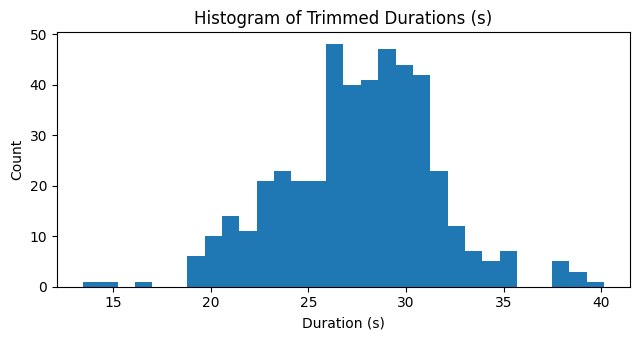

Files with no voiced region found: 0.00%
Playing: /teamspace/studios/this_studio/Original_datasets/KiwiTrimmed/M9/1_2020_9_30_0_19_trim.wav


Playing: /teamspace/studios/this_studio/Original_datasets/KiwiTrimmed/F3/Hawdon-EbbNest201213_20121229_023001_388-GSKfemale_trim.wav


Playing: /teamspace/studios/this_studio/Original_datasets/KiwiTrimmed/M9/6_2020_10_23_1_34_trim.wav


In [7]:
import pandas as pd
from pathlib import Path
from IPython.display import Audio, display

csv_path = output_dir / "trimming_log.csv"
assert csv_path.exists(), "Run the batch cell first to generate the log."

log_df = pd.read_csv(csv_path)
display(log_df.head())

# --- Histogram of trimmed durations ---
if 'HAVE_MPL' in globals() and HAVE_MPL:
    plt.figure(figsize=(6.5, 3.5))
    plt.title("Histogram of Trimmed Durations (s)")
    plt.hist(log_df["trimmed_duration_s"].dropna(), bins=30)
    plt.xlabel("Duration (s)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("[INFO] Matplotlib not available; skipping duration histogram.")

# --- Fraction with no voiced region (lower is better) ---
none_found = (log_df["kept_mode"] == "none_found").mean() if len(log_df) else 0.0
print(f"Files with no voiced region found: {none_found*100:.2f}%")

# --- Listen to a few random examples ---
def _find_output_for_log_row(row: pd.Series) -> Path | None:
    """
    Reconstruct the expected output path by searching under output_dir.
    We search because the batch mirrored subfolders but the CSV only logs the filename.
    """
    stem = Path(row["file"]).stem
    if row["kept_mode"] in ("trim_edges", "librosa_trim"):
        pattern = f"**/{stem}_trim.wav"
    elif row["kept_mode"] == "segment":
        # first segment for preview
        pattern = f"**/{stem}_seg00.wav"
    else:
        return None
    matches = list(output_dir.rglob(pattern))
    return matches[0] if matches else None

# Choose up to 3 random rows to audition
if len(log_df) > 0:
    sample_rows = log_df.sample(min(3, len(log_df)), random_state=42)
    for _, row in sample_rows.iterrows():
        out_path = _find_output_for_log_row(row)
        if out_path and out_path.exists():
            try:
                y2, sr2 = sf.read(str(out_path), always_2d=False)
                if y2.ndim > 1:
                    y2 = y2.mean(axis=1)
                y2 = y2.astype(np.float32)
                print("Playing:", out_path)
                display(Audio(y2, rate=sr2))
            except Exception as e:
                print(f"[WARN] Could not load {out_path}: {e}")
        else:
            print(f"[INFO] Output not found for {row['file']} (mode={row['kept_mode']}).")


## 7) Notes & Tips

- If you see **false positives** (noise detected as call), raise `k_std` (e.g., 4–5) or increase `noise_percentile`.
- If you see **missed onsets/offsets**, try lowering the detection threshold slightly or increasing `prepad_sec` / `postpad_sec`.
- If background hum dominates, try enabling the **band-pass filter** around the target frequency range of the calls.
- If calls are **multi-syllabic** with tiny gaps, increase `merge_gap_sec` (e.g., 0.2–0.3 s) to merge them into a single segment.
- For very short chirps, reduce `min_segment_sec` down to ~0.05–0.10 s.
- Always validate results with the preview cell before running the batch process on all files.
